In [1]:
# Suppress Import Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Start Generation for Bigquery Client and Download Data For Station Visualization
import os
from google.cloud import bigquery

client = bigquery.Client.from_service_account_json("creds/personal_creds.json")

station_sql = """
SELECT
  DISTINCT start_station_id AS station_id,# Unique identifier of a station.
  start_station_name AS staton_name # Public name of the station.
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
"""

station_id_df = client.query_and_wait(station_sql).to_dataframe()

In [4]:
# Explore the various random Stations that can be found.
station_id_df[0:10]

,station_id,staton_name
0,3577,34 Ave & 21 St
1,3635,W 36 St & 9 Ave
2,127,Barrow St & Hudson St
3,3102,Driggs Ave & Lorimer St
4,483,E 12 St & 3 Ave
5,469,Broadway & W 53 St
6,3055,Greene Ave & Nostrand Ave
7,325,E 19 St & 3 Ave
8,284,Greenwich Ave & 8 Ave
9,3297,6 St & 7 Ave


## Detect when a particular CitiBike Station is about to run out of inventory. Less than one bike or more than 30.

#### Initial assumptions:
1. Station table will match to trips table for station ids.
2. Records will exist for managing situations when bikes exceed max capacity

In [5]:
"""Notes:

  Wanted to push the actual dataset configuration up to BigQuery here. This will allow for me to
  take advantage of what BigQuery is good at which is they querying and summarizing of mass sets of
  data. With the first pass completed in BigQuery I know that the set of data that I am bringing down
  to run analysis on my local machine will be better sized for processing on my local machine.
"""
# Execution of Query for pulling information about creating a cumulative count of station bike fill. Please note that you need to set the Station ID to have the process work.

station_id = 483
 
analyze_station_df = f"""
WITH
  exchange_calculation AS (
  SELECT
    start_station_name,
    bikeid,
    starttime AS exchange_date,
    -1 AS bikecount
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE
    start_station_id = {station_id}
  UNION ALL
  SELECT
   start_station_name,
    bikeid,
    stoptime AS exchange_date,
    1 AS bikecount
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE
    end_station_id = {station_id}
  UNION ALL
  SELECT
    null AS start_station_name,
    00000 AS bikeid,
    '2010-01-01' AS exchange_date,
    20 AS bikecount ),
  tracker AS (
  SELECT
    *,
    SUM(bikecount) OVER (ORDER BY exchange_date) AS cum_sum
  FROM
    exchange_calculation
  ORDER BY
    exchange_date )
SELECT
  *
FROM
  tracker
WHERE
  exchange_date <= (
  SELECT
    exchange_date
  FROM
    tracker
  WHERE
    cum_sum IN (30, 0)
  LIMIT
    1)
"""
station_df = client.query_and_wait(analyze_station_df).to_dataframe()


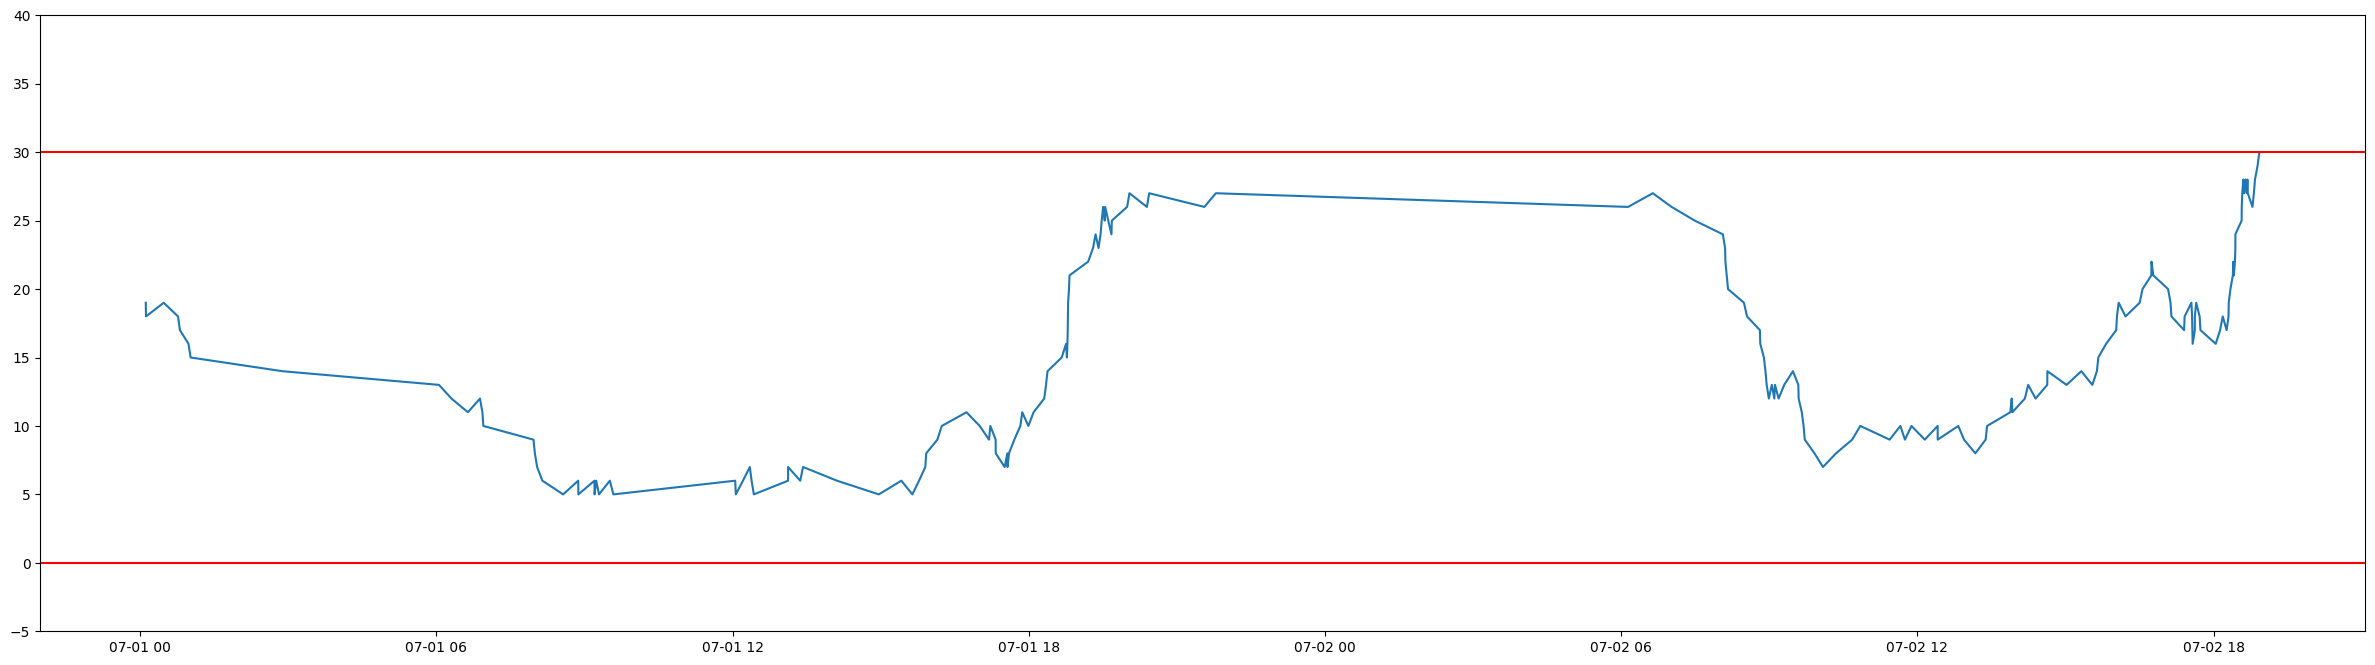

In [13]:
new_df = station_df.loc[station_df['bikeid'] != 0]
plt.plot(new_df["exchange_date"], new_df["cum_sum"])
plt.rcParams["figure.figsize"] = (30,8)

plt.axhline(y=30, color='r', linestyle='-')
plt.axhline(y=0, color='r', linestyle='-')

plt.ylim(-5,40)
plt.show()


In [7]:
# Find out when the station being reviewd here has either reached empty or full and whne that has happened
new_df.iloc[[-1]].to_json()

'{"start_station_name":{"200":"1 Ave & E 44 St"},"bikeid":{"200":19073},"exchange_date":{"200":1372791347},"bikecount":{"200":1},"cum_sum":{"200":30}}'

#### Findings:
The above SQL Query will return a dataset that will filter up until the point that the stations are either full of, or out of inventory. This can at least serve as a base for building a set of data to be able to build out a function capable of taking in a yet to be constructed table in BigQuery. This function can then take in entries as they arrive for completed rides, and determine if a notification needs to be sent out to Citibike Station Managers to address station inventory issues.

Eventually this data could be used to predict when certain stations either should have attendents on standby to either empty or fill stations are natural swings of use occur throughout the course of the day, or build out a list of stations for upgrade to storage capacity.


In [8]:
new_df.loc[station_df['bikeid'] != 0]

,start_station_name,bikeid,exchange_date,bikecount,cum_sum
1,E 12 St & 3 Ave,19900,2013-07-01 00:06:54,-1,19
2,E 12 St & 3 Ave,18295,2013-07-01 00:07:10,-1,18
3,W 20 St & 7 Ave,20517,2013-07-01 00:28:42,1,19
4,E 12 St & 3 Ave,18582,2013-07-01 00:46:05,-1,18
5,E 12 St & 3 Ave,16801,2013-07-01 00:48:22,-1,17
...,...,...,...,...,...
196,E 12 St & 3 Ave,17897,2013-07-02 18:47:20,-1,26
197,Lafayette St & E 8 St,15889,2013-07-02 18:49:03,1,27
198,Hudson St & Reade St,17222,2013-07-02 18:50:24,1,28
199,E 17 St & Broadway,17568,2013-07-02 18:53:30,1,29


## Evaluate if there is a way to detect lost or stolen bikes.

#### Initial assumptions:
1. Will be possible to detect stolen bikes by records of ridership where there are null values related to endtrip, or null values for trip duration.
2. Any trip lasting longer than could indicate a stolen bike or missing bike
    - 1.5 Hours for Customers (5400 seconds)
    - 2 Hours for Subscribers (7200)

In [9]:
"""
Quick gut check on the shape of the DataFrame where starttime is a value, but there is no stoptime. Assumption here is that with the
  trip log data existing is that we might be able to identify records based on how they are inserted/ updated in the table. My guess here
  was that trips would be inserted into the table upon start, and then that trip would be updated as it is completed. This assumption
  seems to have been proven wrong here at least within this table. A trip here seems to only be classified as a trip when it has been completed.


While this is great for logging trips it does leave something to be desired for if we are to exclusively use the trips table as the sole source
  of information for determining bike lost/ stolen status. With this table we would only then be able to determne lost/ stolen status of a bike
  that has been returned to a station. This would maybe help us determine whether or not there are stations we should monitor, or potentially users
  who we should monitor that are repeat 'offenders' of being careless with our product.
  
We would not be able to live call out bikes with this table that are missing. We would need another table, or access to some object that is monitoring
  bike trip status to determine live call outs for bike being in lost/ stolen status.
"""

null_value_check_sql = """
SELECT
  *
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE
  starttime IS NOT NULL
  AND stoptime IS NULL
LIMIT
  10
"""
trip_duration_df = client.query_and_wait(null_value_check_sql).to_dataframe()
trip_duration_df.shape


(0, 16)

In [10]:
"""
Second gut check here was to review the tripduration overall across the entire dataset. I did a quick refresher on the upper bound limit
  of how long users (whether they be customers or subscribers) can keep bikes until extra fees are tacked onto their ride. For Customers
  the first 30 minutes they are free, and then for Subscribers the first 45 minutes of a ride are free. 

  For the sake of capturing trips I decided to use a case statement to create buckets of time of thitry minutes each up to 2 hours. Then
  for each customer type if the trip duration exceeds my assumptions above then marking them as either true false for lost/stolen.

https://help.citibikenyc.com/hc/en-us/articles/360032024912-How-long-can-I-keep-a-bike-out
"""

# Initial Data Discovery
trip_duration_sql = """
WITH
  trip_grouping AS (
  SELECT
    usertype,
    tripduration,
    CASE
      WHEN tripduration BETWEEN 0 AND 1800 THEN 1800
      WHEN tripduration BETWEEN 1801
    AND 3600 THEN 3600
      WHEN tripduration BETWEEN 3601 AND 5400 THEN 5400
      WHEN tripduration BETWEEN 5401
    AND 7200 THEN 7200
      WHEN tripduration BETWEEN 7201 AND 9000 THEN 9000
    ELSE
    9001
  END
    AS trip_buckets
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE
    start_station_id IS NOT NULL),
  summary AS (
  SELECT
    usertype,
    trip_buckets,
    COUNT(*) AS bucket_count,
    SUM(COUNT(*)) OVER (PARTITION BY usertype) AS group_total
  FROM
    trip_grouping
  GROUP BY
    usertype,
    trip_buckets
  ORDER BY
    usertype,
    trip_buckets)
SELECT
  usertype,
  trip_buckets,
  bucket_count,
  group_total,
  CASE
    WHEN usertype = 'Customer' AND trip_buckets < 5400 THEN FALSE
    WHEN usertype = 'Subscriber'
  AND trip_buckets < 7200 THEN FALSE
  ELSE
  TRUE
END
  AS lost_stolen_flag,
  ROUND((bucket_count/group_total)*100, 2) AS p_of_user
FROM
  summary
"""

trip_duration_df = client.query_and_wait(trip_duration_sql).to_dataframe()
trip_duration_df

,usertype,trip_buckets,bucket_count,group_total,lost_stolen_flag,p_of_user
0,Customer,1800,4806519,6191149,False,77.64
1,Customer,3600,1006746,6191149,False,16.26
2,Customer,5400,178543,6191149,True,2.88
3,Customer,7200,74047,6191149,True,1.20
4,Customer,9000,38608,6191149,True,0.62
5,Customer,9001,86686,6191149,True,1.40
6,Subscriber,1800,44407631,46917572,False,94.65
7,Subscriber,3600,2328967,46917572,False,4.96
8,Subscriber,5400,81295,46917572,False,0.17
9,Subscriber,7200,26113,46917572,True,0.06


In [11]:
# With the above in mind a simple query like the below could be written in order to identify bikeids that have at some point in time been lost/ stolen.

bike_theft_sql = """
SELECT
  tripduration,
  usertype,
  * EXCEPT (tripduration,
    usertype)
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE
  usertype = 'Customer'
  AND tripduration >= 5400
  OR usertype = 'Subscriber'
  AND tripduration >= 7200
LIMIT
  10

"""

bike_theft_df = client.query_and_wait(bike_theft_sql ).to_dataframe()
t = bike_theft_df['bikeid']
print(t.to_json(orient='values', indent=4))



[
    14688,
    22689,
    19086,
    16641,
    23400,
    14647,
    22261,
    22802,
    15027,
    25141
]


#### Findings:
While the above is not a perfect system to help us identify bikes that have been stolen or lost is does give us an idea of how to work with the current dataset to identify either users or stations that might be problematic. Good findings are that from our assumed definiton Customer Bikes are 94% not lost/ stolen, and Subsriber bikes are 99.61% classified as not lost/stolen from trip data.

This at least gives us an idea, if we are forced to use this dataset to identify lost or stolen bikes, that we could use tripduration and usertype to aid in the identification of bikes that have been lost or stolen. Just only if they have been returned.

